<a href="https://colab.research.google.com/github/Ayikanying-ux/basic_text_classification/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic text classification
In this project, we will train a binary classifier to perform sentiment analysis on an IMDB dataset.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.15.0


## Sentiment analysis
First of all what is sentiment analysis. This is the process of determining emotional tone expressed in a text. It can either be negative, positive or neutral.

## Data
In this project we shall use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These will be split into 25000 review for training and 25000 reviews for testing

## Downloading and exploring the IMDB dataset

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")


84125825/84125825 [==============================] - 12s 0us/step


In [4]:
os.listdir(dataset_dir)

['README', 'train', 'imdb.vocab', 'test', 'imdbEr.txt']

In [5]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['unsupBow.feat',
 'pos',
 'neg',
 'urls_neg.txt',
 'urls_pos.txt',
 'unsup',
 'urls_unsup.txt',
 'labeledBow.feat']

The ```aclImdb/train/pos``` and ```aclImdb/train/neg``` directories contain many text files, each of which is a single moview review. Lets take a look at one of them

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Load the dataset
Next, load the data off the disk and prepare it into a format suitable for training.

To prepare a dataset for binary classification, we will need two folders on disk. These will be the positive and negative movie reviews

In [7]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)
os.listdir(train_dir)

['unsupBow.feat',
 'pos',
 'neg',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt',
 'labeledBow.feat']

Next will use the ```text_dataset_from_directory``` utility to create a labelled ```tf.data.Dataset```.tf.Data is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation, and test

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text(with punctuation and occassional HTML tags like ```<br/>```). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the ```class_names``` property on dataset.

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Now let's create a validation and test dataset

In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


## Prepare the dataset for training
Next we will standardize, tokenize, and vectorize the data using the helpful ```tf.keras.layers.TextVectorization``` layer.

Standardization refers to preprocessing the text, typically to remove punctuation of HTML elements to simplify the dataset. Tokenization refers to splitting the strings into tokens( for example splitting a sentence into individual words, by splitting on white space). Vectorization refers to converting tokens into numbers so they can be fed into a neural network.

In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation),
                                  '')

Next, will create a ```TextVectorization``` layer. This will standardize, tokenize, and vectorize out data. Set the ```output_mode``` to ```int``` to create unique interger indices for each token.

Note that using the default split function, and the custom standardizatin function you defined above. You'll also define some constants for the model, like an explicit maximum ```sequence_length```, which will cause the layer to pad or truncate sequence to exactly ```sequence_length``` values

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)

Next is to call ```adapt``` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers

In [15]:
train_text=raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

So now let's lookup the token (string) that each integer corresponds to by calling the ```get_vocabulary()``` on the layer

In [18]:
print("1287 --->", vectorize_layer.get_vocabulary()[1287])
print("313 --->", vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 ---> silent
313 ---> night
Vocabulary size: 10000


Now let's apply the TextVectorization layer on the train, validation, and test dataset

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking

```.cache()``` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. if your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

```.prefetch()``` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the ```data performance guide```

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [22]:
embedding_dim=16

In [23]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

The layers are stacked sequentially to build the classifier:



1.   The first layer is an ```Embedding``` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array.
The resulting dimensions are: (```batch, sequence, embedding```). to learn more about embeddings, check out the Word embeddings tutorial.

2.   Next, a ```GlobalAveragePooling1D``` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible

3. The last layer is densely connected with a single output node.

## Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability( a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

Now, configure the model to use an optimizer and a loss function



In [25]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

## Train the model

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6637 - binary_accuracy: 0.6974 - val_loss: 0.6139 - val_binary_accuracy: 0.7738
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5478 - binary_accuracy: 0.8004 - val_loss: 0.4972 - val_binary_accuracy: 0.8226
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4435 - binary_accuracy: 0.8454 - val_loss: 0.4193 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3780 - binary_accuracy: 0.8668 - val_loss: 0.3731 - val_binary_accuracy: 0.8622
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3345 - binary_accuracy: 0.8785 - val_loss: 0.3444 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3044 - binary_accuracy: 0.8889 - val_loss: 0.3254 - val_binary_accuracy: 0.8730
Epoch 7/10
625/625 [==============================] - 5s 8ms

## Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy

In [28]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 11s 13ms/step - loss: 0.3102 - binary_accuracy: 0.8731
Loss:  0.3101758360862732
Accuracy:  0.8730800151824951


## Creating a plot of accuracy and loss over time

```model.fit()``` returns a ```History``` object that contains a dictionary with everything that happened during training:

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

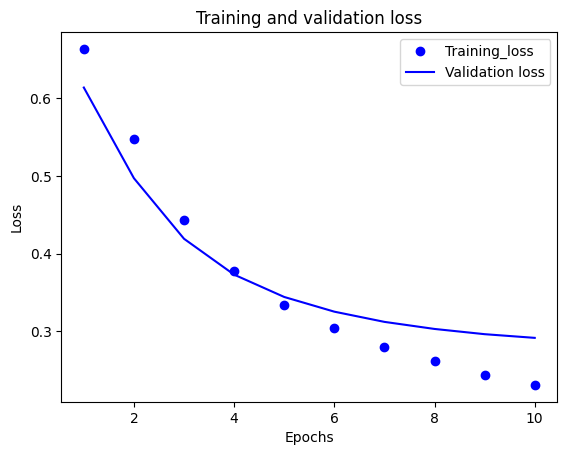

In [30]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, "bo", label='Training_loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

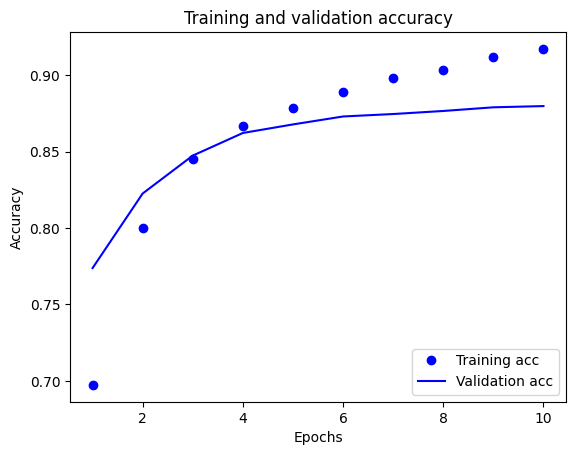

In [31]:
plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization - it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy - they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point. the model over-optimizes and learn representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increassing. One way to do so is to use the ```tf.keras.callbacks.EarlyStopping``` callback.

## Export the model

In the code above, you applied the ```TextVectorization``` layer to the dataset before feed text to the model. If you want to make your model capable of processing raw strings(for example, to simplify deploying it), you can include the ```TextVectorization``` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [33]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 13s 15ms/step - loss: 0.5883 - accuracy: 0.5000
0.5


## Inference on new data

In [36]:
examples = tf.constant([
    "The movie was great",
    "The movie was okay",
    "The movie was terrible..."
])
export_model.predict(examples)

1/1 [==============================] - 0s 140ms/step


array([[0.64822984],
       [0.6061417 ],
       [0.58670706]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for train/test skew.

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment
